In [22]:
import torch
import torchvision
import torchvision.transforms as transforms

In [23]:

import os
import PIL
import torch
import numpy as np
import pandas as pd
from torch.utils.data import Dataset
import glob
import cv2 as cv
from sklearn.model_selection import train_test_split
import pandas as pd
from torchvision.io import read_image
import torchdata as td
from torch.utils.data import DataLoader
from skimage import data, io
from torchvision.utils import make_grid
#Set seeds
# np.random.seed(0)
# torch.manual_seed(0)
# torch.cuda.manual_seed(0)
# torch.cuda.manual_seed_all(0)

# data directory 
BATCH_SIZE = 4
NUM_WORKER = 0
IMAGE_SIZE = 64

class CougDataset(Dataset):
    def __init__(self, img_dir, transform):
        self.image_paths = self._create_paths(glob.glob(img_dir + "\\*"))
        self.classes = [self._get_class_from_image_path for path in self.image_paths]
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_filepath = self.image_paths[idx]
        image = cv.imread(image_filepath)
        image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
        label = self._get_class_from_image_path(image_filepath)
        if self.transform is not None:
            image = self.transform(image)
        return image, label

    def _create_paths(self, all_paths):
        return [str(path) for path in all_paths]

    def _get_class_from_image_path(self, image_path):
        class_name = image_path.split("\\")[-1].split("_")[0]
        if class_name == "coug":
            return 1
        else:
            return 0



In [24]:
img_dir = "C:\\Users\\ahmet\\Desktop\\ME 485\\magcougdataset\\cougnotcoug"
data_transform = transforms.Compose(
        [
            transforms.ToPILImage(),
            transforms.Resize(IMAGE_SIZE, max_size=IMAGE_SIZE * 2),
            transforms.RandomCrop(IMAGE_SIZE, pad_if_needed=True),
            transforms.ToTensor(),
             torchvision.transforms.Normalize(
                (0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
            # ),
        ]
    )

full_dataset = CougDataset(img_dir=img_dir, transform=data_transform)
train_size = int(0.8 * len(full_dataset))
test_size = len(full_dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(
full_dataset, [train_size, test_size]
    )
train_loader = DataLoader(
    train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKER
)
test_loader = DataLoader(
    test_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKER
)


In [25]:

classes = ('notcoug', 'coug')

print(f"train_size: {train_size}, test_size: {test_size}")

print(
    "The shape of tensor for 50th image in train dataset: ",
    train_dataset[49][0].shape,
)
print("The label for 50th image in train dataset: ", train_dataset[49][1])


train_size: 3712, test_size: 928
The shape of tensor for 50th image in train dataset:  torch.Size([3, 64, 64])
The label for 50th image in train dataset:  1


In [26]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(2704, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

In [27]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [29]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 100 == 99:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

[1,   100] loss: 0.031
[1,   200] loss: 0.032
[1,   300] loss: 0.031
[1,   400] loss: 0.028
[1,   500] loss: 0.029
[1,   600] loss: 0.030
[1,   700] loss: 0.029
[1,   800] loss: 0.029
[1,   900] loss: 0.028
[2,   100] loss: 0.026
[2,   200] loss: 0.027
[2,   300] loss: 0.030
[2,   400] loss: 0.026
[2,   500] loss: 0.028
[2,   600] loss: 0.026
[2,   700] loss: 0.025
[2,   800] loss: 0.027
[2,   900] loss: 0.024
Finished Training


In [30]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

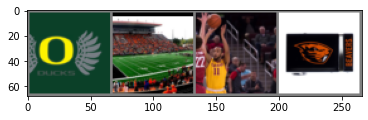

notcoug notcoug coug  notcoug


In [31]:
dataiter = iter(test_loader)
images, labels = dataiter.next()

images, labels = dataiter.next()
grid = torchvision.utils.make_grid(images).numpy()
grid = grid / 2 + 0.5
plt.imshow(np.transpose(grid, (1, 2, 0)))
plt.show()
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(BATCH_SIZE)))



In [32]:
net = Net()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


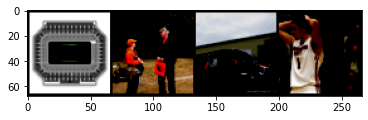

GroundTruth:  notcoug notcoug notcoug coug 
Predicted:  notcoug notcoug notcoug coug 


In [33]:
images, labels = dataiter.next()

grid = torchvision.utils.make_grid(images).numpy()

plt.imshow(np.transpose(grid, (1, 2, 0)))
plt.show()

# print(' '.join(f'{classes[labels[j]]:5s}' for j in range(BATCH_SIZE)))

outputs = net(images)

_, predicted = torch.max(outputs, 1)

print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(BATCH_SIZE)))
print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}' for j in range(BATCH_SIZE)))

In [34]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 75 %


In [35]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1

# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: notcoug is 79.5 %
Accuracy for class: coug  is 64.7 %
